# Assignment 02

In [6]:
import os
import io
import time
import math
import requests
import networkx as nx
import acopy
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import itertools
from tspy import TSP
from tspy.solvers import TwoOpt_solver
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
from matplotlib import cm
from collections import Counter

## Question 2 (TSP)

### (b) Reads the GML files

In [24]:
! pip install tspy

Defaulting to user installation because normal site-packages is not writeable


In [14]:
tsp_folder = "../data/tsp"
gml_files = [f for f in os.listdir(tsp_folder) if f.endswith(".gml")]
for gml_file in gml_files:
    graph_path = os.path.join(tsp_folder, gml_file)
    G = nx.read_gml(graph_path)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f"Graph: {gml_file}")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}\n")

Graph: berlin52.gml
Number of nodes: 52
Number of edges: 2652

Graph: brazil58.gml
Number of nodes: 58
Number of edges: 3306

Graph: brg180.gml
Number of nodes: 180
Number of edges: 32220

Graph: gr229.gml
Number of nodes: 229
Number of edges: 52212

Graph: pr439.gml
Number of nodes: 439
Number of edges: 192282



### (e) Run the code on  each graphs

**Attempt 1: Ant colony optimization**

Where the code be found in website https://acopy.readthedocs.io/en/latest/usage.html, which is not a very successful attempt since the time complexity is too high, not very scalable

In [20]:
tsp_folder = "../data/tsp"
gml_files = [f for f in os.listdir(tsp_folder) if f.endswith(".gml")]
runtimes = []
graph_sizes = []

solver = acopy.Solver(rho=0.03, q=1)
colony = acopy.Colony(alpha=1, beta=3)

for gml_file in gml_files:
    graph_path = os.path.join(tsp_folder, gml_file)
    G = nx.read_gml(graph_path)
    for u, v, data in G.edges(data=True):
        if 'cost' in data:
            data['weight'] = data.pop('cost')
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    run_times = []
    for i in range(1):  # Run multiple times for averaging
        start_time = time.time()
        solver.solve(G, colony,limit=1)        
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    avg_runtime = sum(run_times) / len(run_times)
    runtimes.append(avg_runtime)
    graph_sizes.append(num_nodes)
    print(f"Graph: {gml_file}")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}\n")
    print(f"Average runtime: {avg_runtime:.4f} seconds\n")

Graph: berlin52.gml
Number of nodes: 52
Number of edges: 2652

Average runtime: 0.2953 seconds

Graph: brazil58.gml
Number of nodes: 58
Number of edges: 3306

Average runtime: 0.4348 seconds

Graph: brg180.gml
Number of nodes: 180
Number of edges: 32220

Average runtime: 29.6414 seconds

Graph: gr229.gml
Number of nodes: 229
Number of edges: 52212

Average runtime: 72.8387 seconds

Graph: pr439.gml
Number of nodes: 439
Number of edges: 192282

Average runtime: 1571.2167 seconds



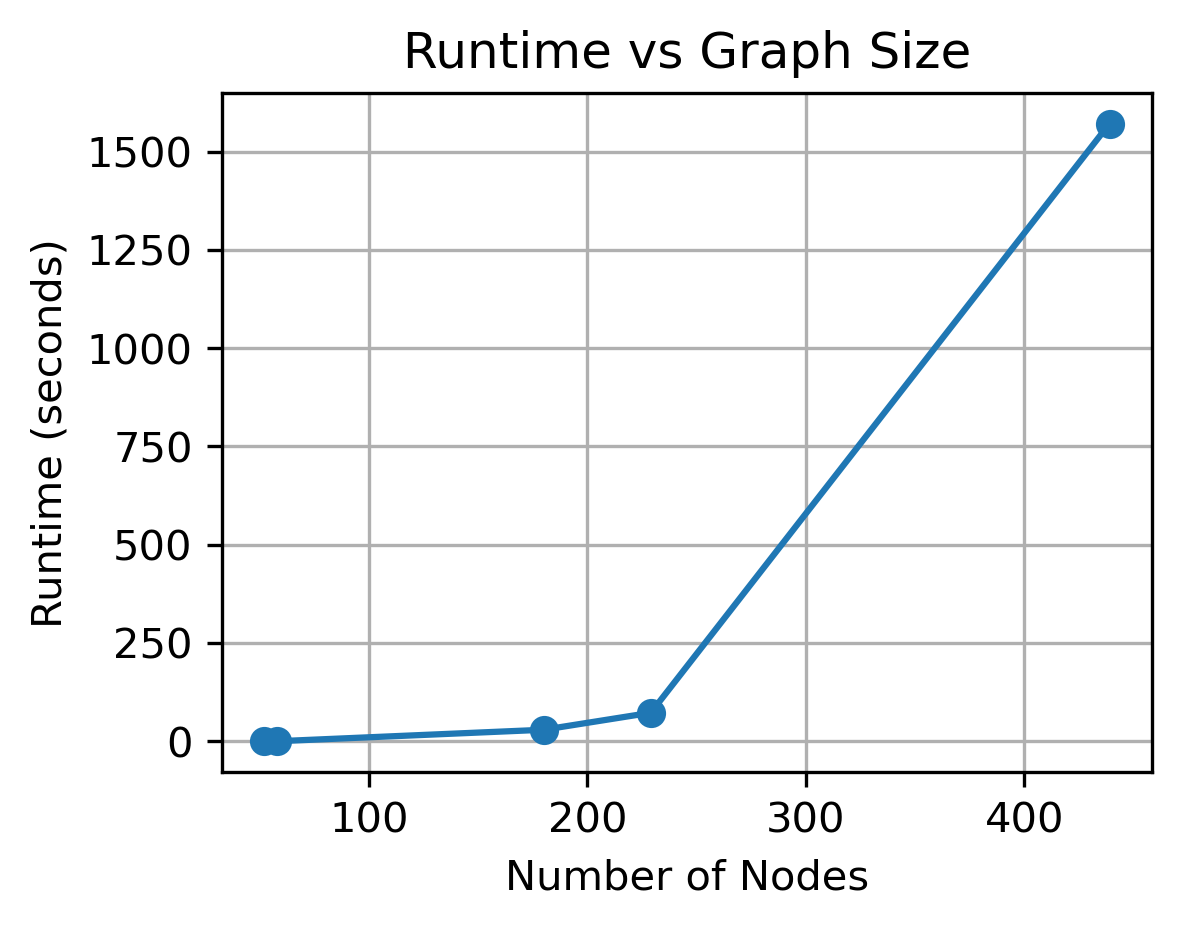

In [22]:
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(graph_sizes, runtimes, marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Graph Size')
plt.grid(True)
plt.show()

**Attempt 2:  2-opt algorithm from tspy**

Where the code could be from https://github.com/wborgeaud/tspy

In [32]:
tsp_folder = "../data/tsp"
gml_files = [f for f in os.listdir(tsp_folder) if f.endswith(".gml")]

runtimes = []
graph_sizes = []

for gml_file in gml_files:
    graph_path = os.path.join(tsp_folder, gml_file)
    G = nx.read_gml(graph_path)
    num_nodes = G.number_of_nodes()
    node_to_index = {node: i for i, node in enumerate(G.nodes())}
    distance_matrix = np.full((num_nodes, num_nodes), np.inf)
    for u, v, data in G.edges(data=True):
        if 'cost' in data:
            u_idx = node_to_index[u]
            v_idx = node_to_index[v]
            distance_matrix[u_idx][v_idx] = data['cost']
            distance_matrix[v_idx][u_idx] = data['cost']
    tsp = TSP()
    tsp.read_mat(distance_matrix)
    two_opt = TwoOpt_solver(initial_tour='NN', iter_num=100)
    run_times = []
    for i in range(5):
        start_time = time.time()
        two_opt_tour = tsp.get_approx_solution(two_opt)
        end_time = time.time()
        
        run_time = end_time - start_time
        run_times.append(run_time)
    avg_runtime = sum(run_times) / len(run_times)
    runtimes.append(avg_runtime)
    graph_sizes.append(num_nodes)
    print(f"TwoOpt Approximate solution tour: {two_opt_tour}")
    print(f"Average runtime over 5 runs: {avg_runtime:.4f} seconds\n")

The cost is 7713.0347593762235.
The cost is 7713.0347593762235.
The cost is 7713.0347593762235.
The cost is 7713.0347593762235.
The cost is 7713.0347593762235.
TwoOpt Approximate solution tour: [39, 37, 36, 45, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 12, 13, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 48, 0, 21, 30, 17, 2, 16, 20, 41, 6, 1, 29, 28, 22, 19, 49, 15, 43, 33, 34, 35, 38, 39]
Average runtime over 5 runs: 0.0120 seconds

The cost is 25704.0.
The cost is 25704.0.
The cost is 25704.0.
The cost is 25704.0.
The cost is 25704.0.
TwoOpt Approximate solution tour: [4, 26, 42, 11, 56, 22, 23, 57, 43, 17, 0, 29, 12, 39, 24, 8, 31, 19, 52, 49, 3, 7, 21, 41, 30, 6, 37, 15, 10, 38, 20, 35, 16, 25, 18, 5, 27, 13, 36, 14, 33, 45, 55, 44, 32, 28, 47, 2, 34, 9, 48, 46, 50, 51, 40, 1, 53, 54, 4]
Average runtime over 5 runs: 0.0277 seconds

The cost is 1970.0.
The cost is 1970.0.
The cost is 1970.0.
The cost is 1970.0.
The cost is 1970.0.
TwoOpt Approximate solution tour: [26, 25, 24, 3

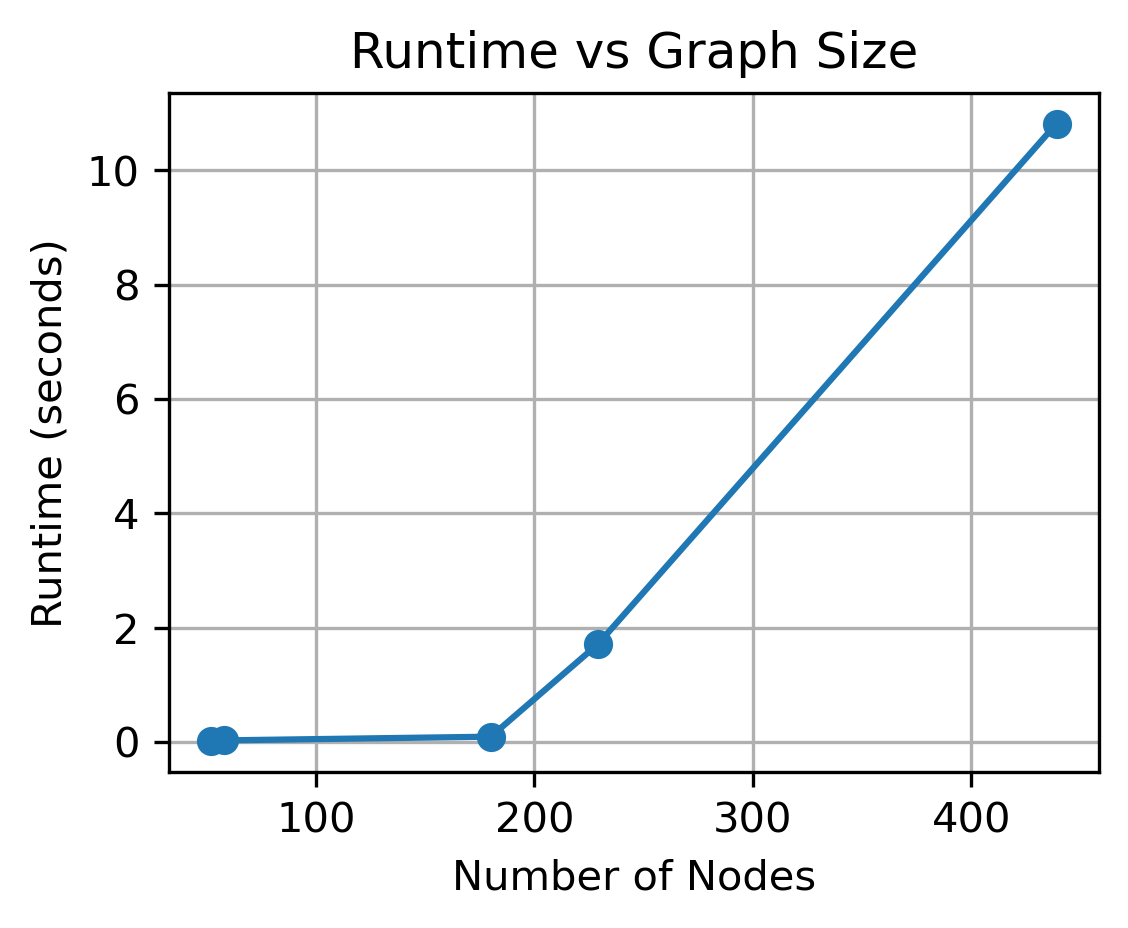

In [35]:
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(graph_sizes, runtimes, marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Graph Size')
plt.grid(True)
plt.show()

## Question 3 Exploring community detections

### (a) Download the network and implement modularity detection

**Choice: european road network**

In [8]:
url = "https://nrvis.com/download/data/inf/inf-euroroad.zip"
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
    edges_filename = next((f for f in thezip.namelist() if f.endswith('.edges')), None)
    if edges_filename is None:
        raise FileNotFoundError("No .edges file found in the ZIP archive.")
    with thezip.open(edges_filename) as edges_file:
        G = nx.Graph()
        for line in edges_file:
            line = line.decode('utf-8').strip()
            if line.startswith('%'):
                continue
            u, v = map(int, line.split())
            G.add_edge(u, v)

In [10]:
len(G.edges())

1417

In [10]:
largest_cc = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(largest_cc).copy()
communities_generator = girvan_newman(G_giant)
top_level_communities = next(communities_generator)
communities = [list(community) for community in top_level_communities]

#Store into dictionary
partition_gn = {}
for community_id, community in enumerate(communities):
    for node in community:
        partition_gn[node] = community_id

/tmp/ipykernel_29650/471737519.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set2', len(community_ids))


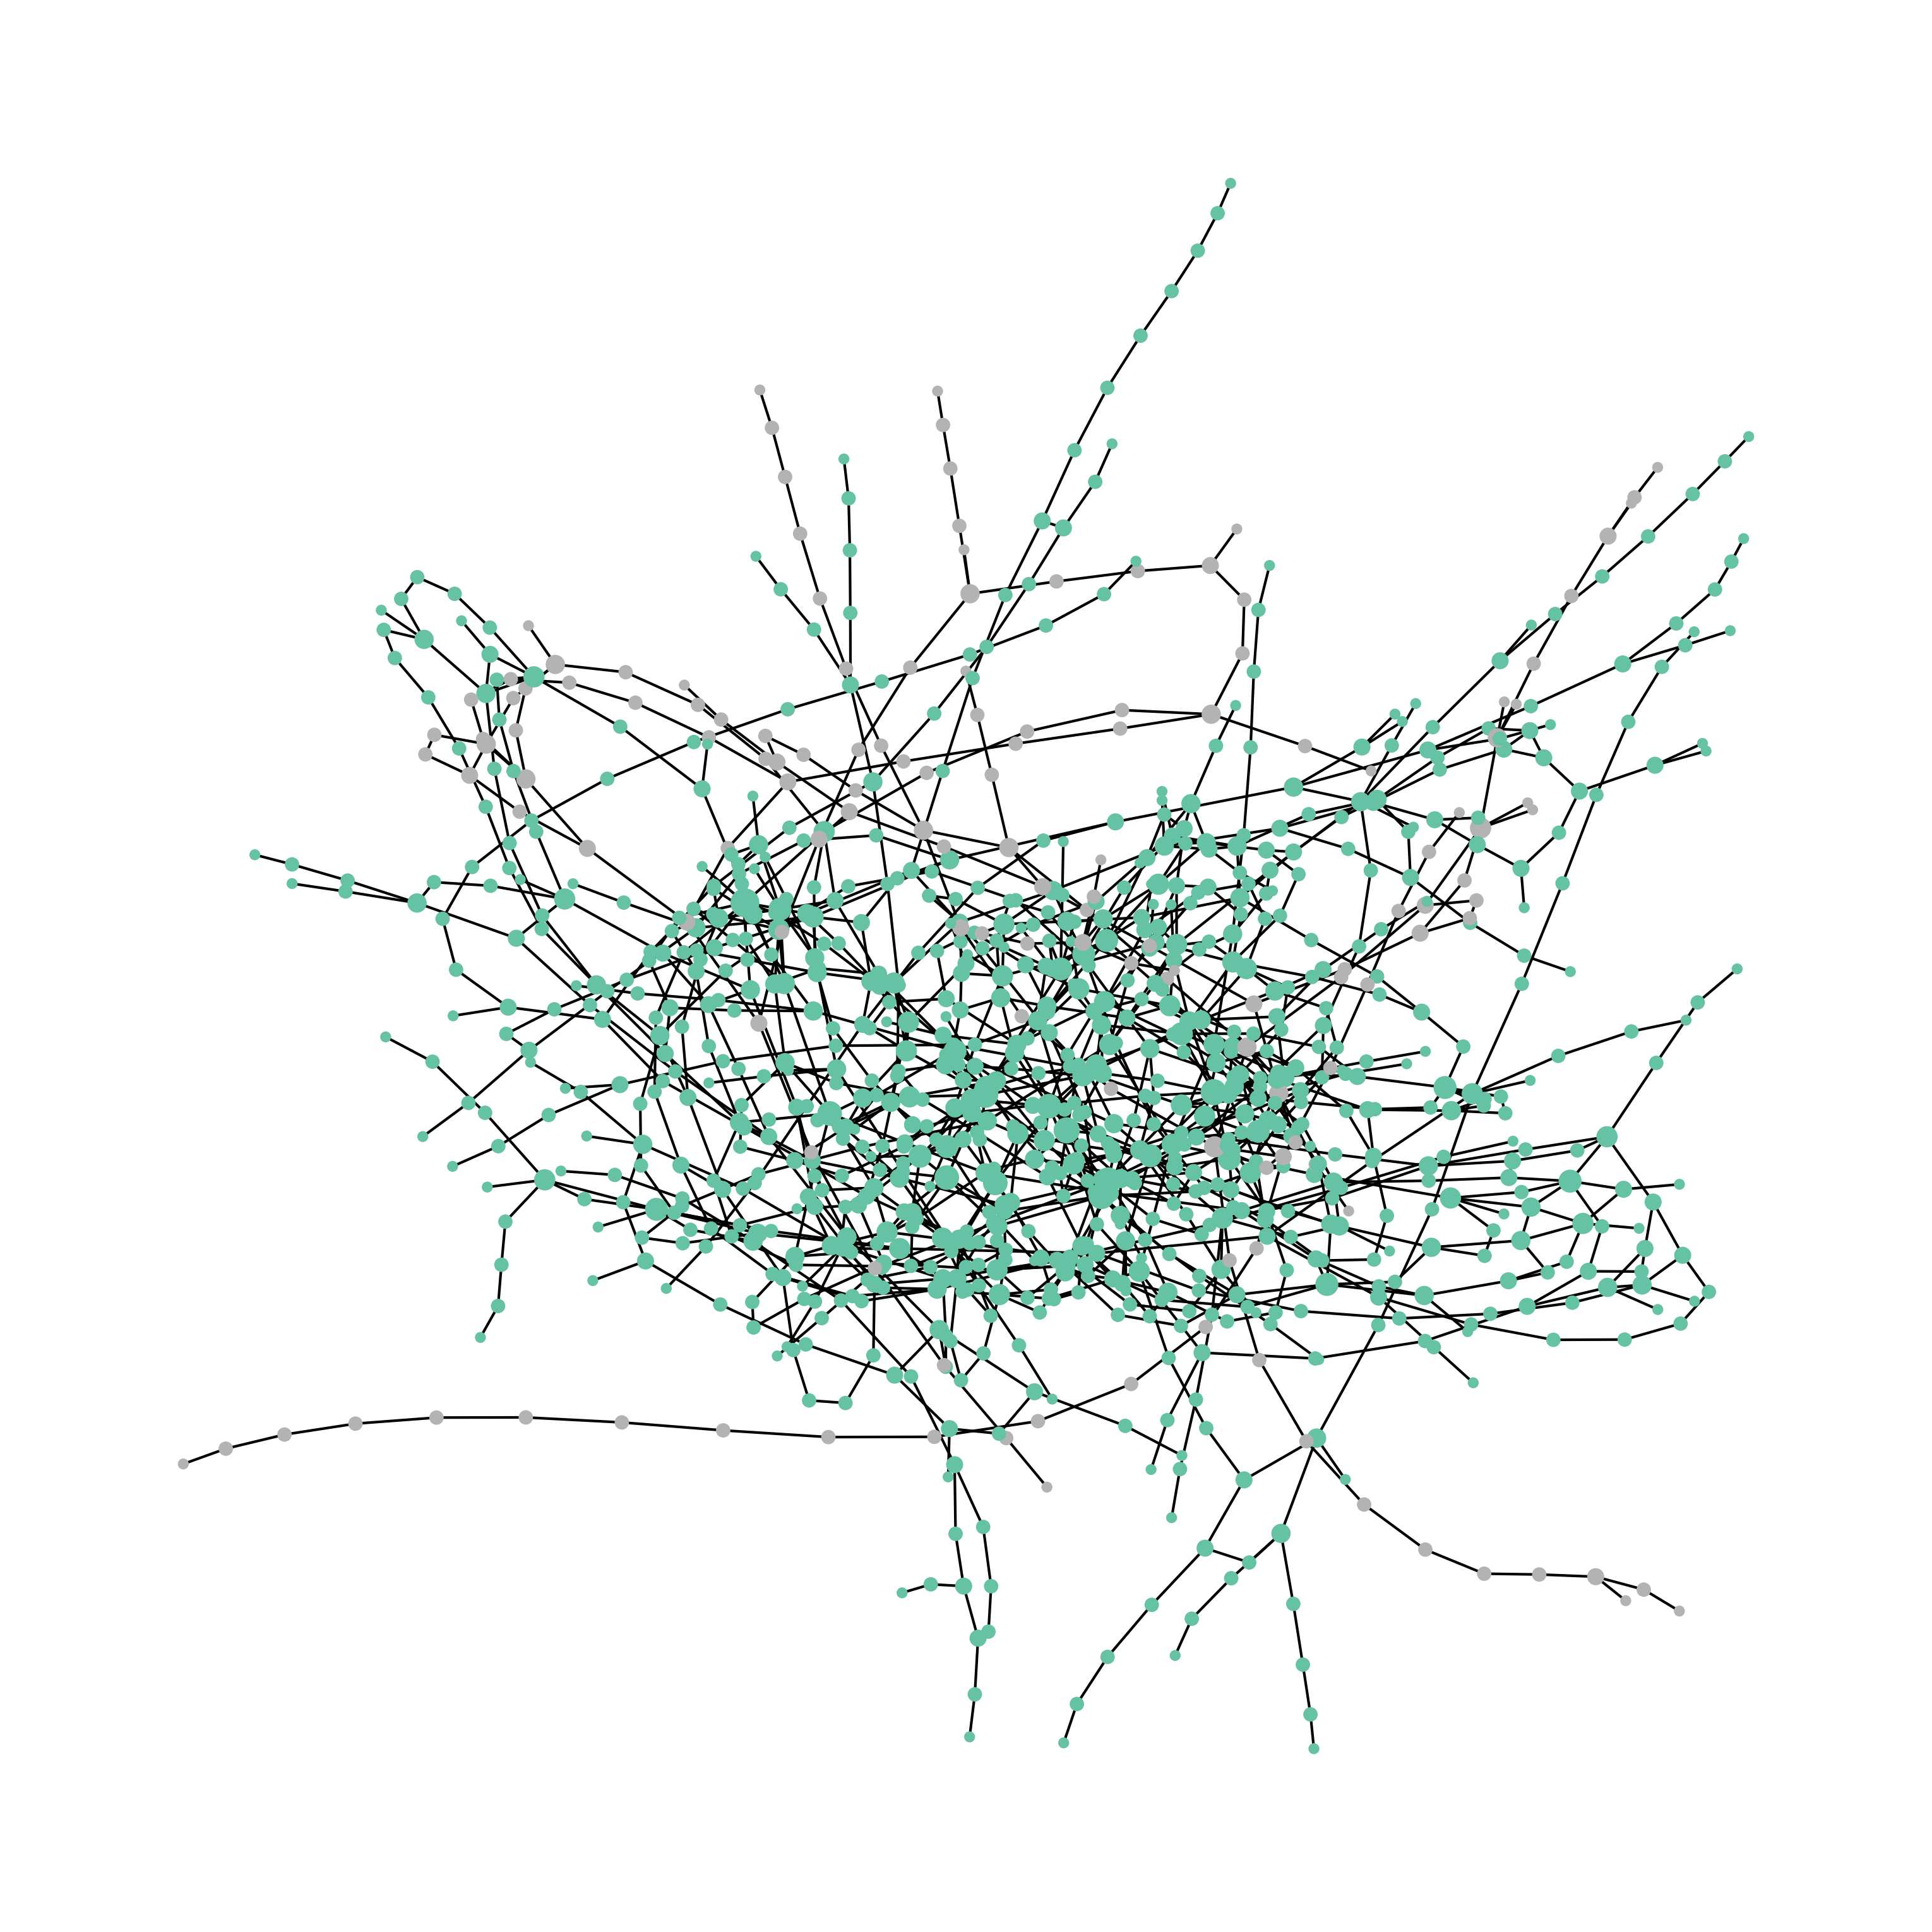

In [28]:
community_ids = list(set(partition_gn.values()))
cmap = cm.get_cmap('Set2', len(community_ids))
colors = [cmap(partition_gn[node]) for node in G_giant.nodes()]
node_sizes = [G_giant.degree(node) * 10 for node in G_giant.nodes()]  # Scale factor can be adjusted

plt.figure(figsize=(10, 10),dpi=300)
pos = nx.spring_layout(G_giant)
nx.draw(G_giant, pos, node_color=colors, node_size=node_sizes, with_labels=False, cmap='Set2')
plt.show()

In [16]:
#Modularity
mod_value = modularity(G_giant, top_level_communities)
print(f"Modularity of the partition: {mod_value}")

Modularity of the partition: 0.21129578250466083


In [17]:
#Number of communities
num_communities = len(communities)
num_communities

2

### (b) Do in graph-tool

In [59]:
import graph_tool.all as gt
def nx_to_gt(nx_graph):
    gt_graph = gt.Graph(directed=False)
    nx_to_gt_map = {}
    for node in nx_graph.nodes:
        nx_to_gt_map[node] = gt_graph.add_vertex()
    for edge in nx_graph.edges(data=True):
        source = nx_to_gt_map[edge[0]]
        target = nx_to_gt_map[edge[1]]
        gt_graph.add_edge(source, target)
    return gt_graph, nx_to_gt_map

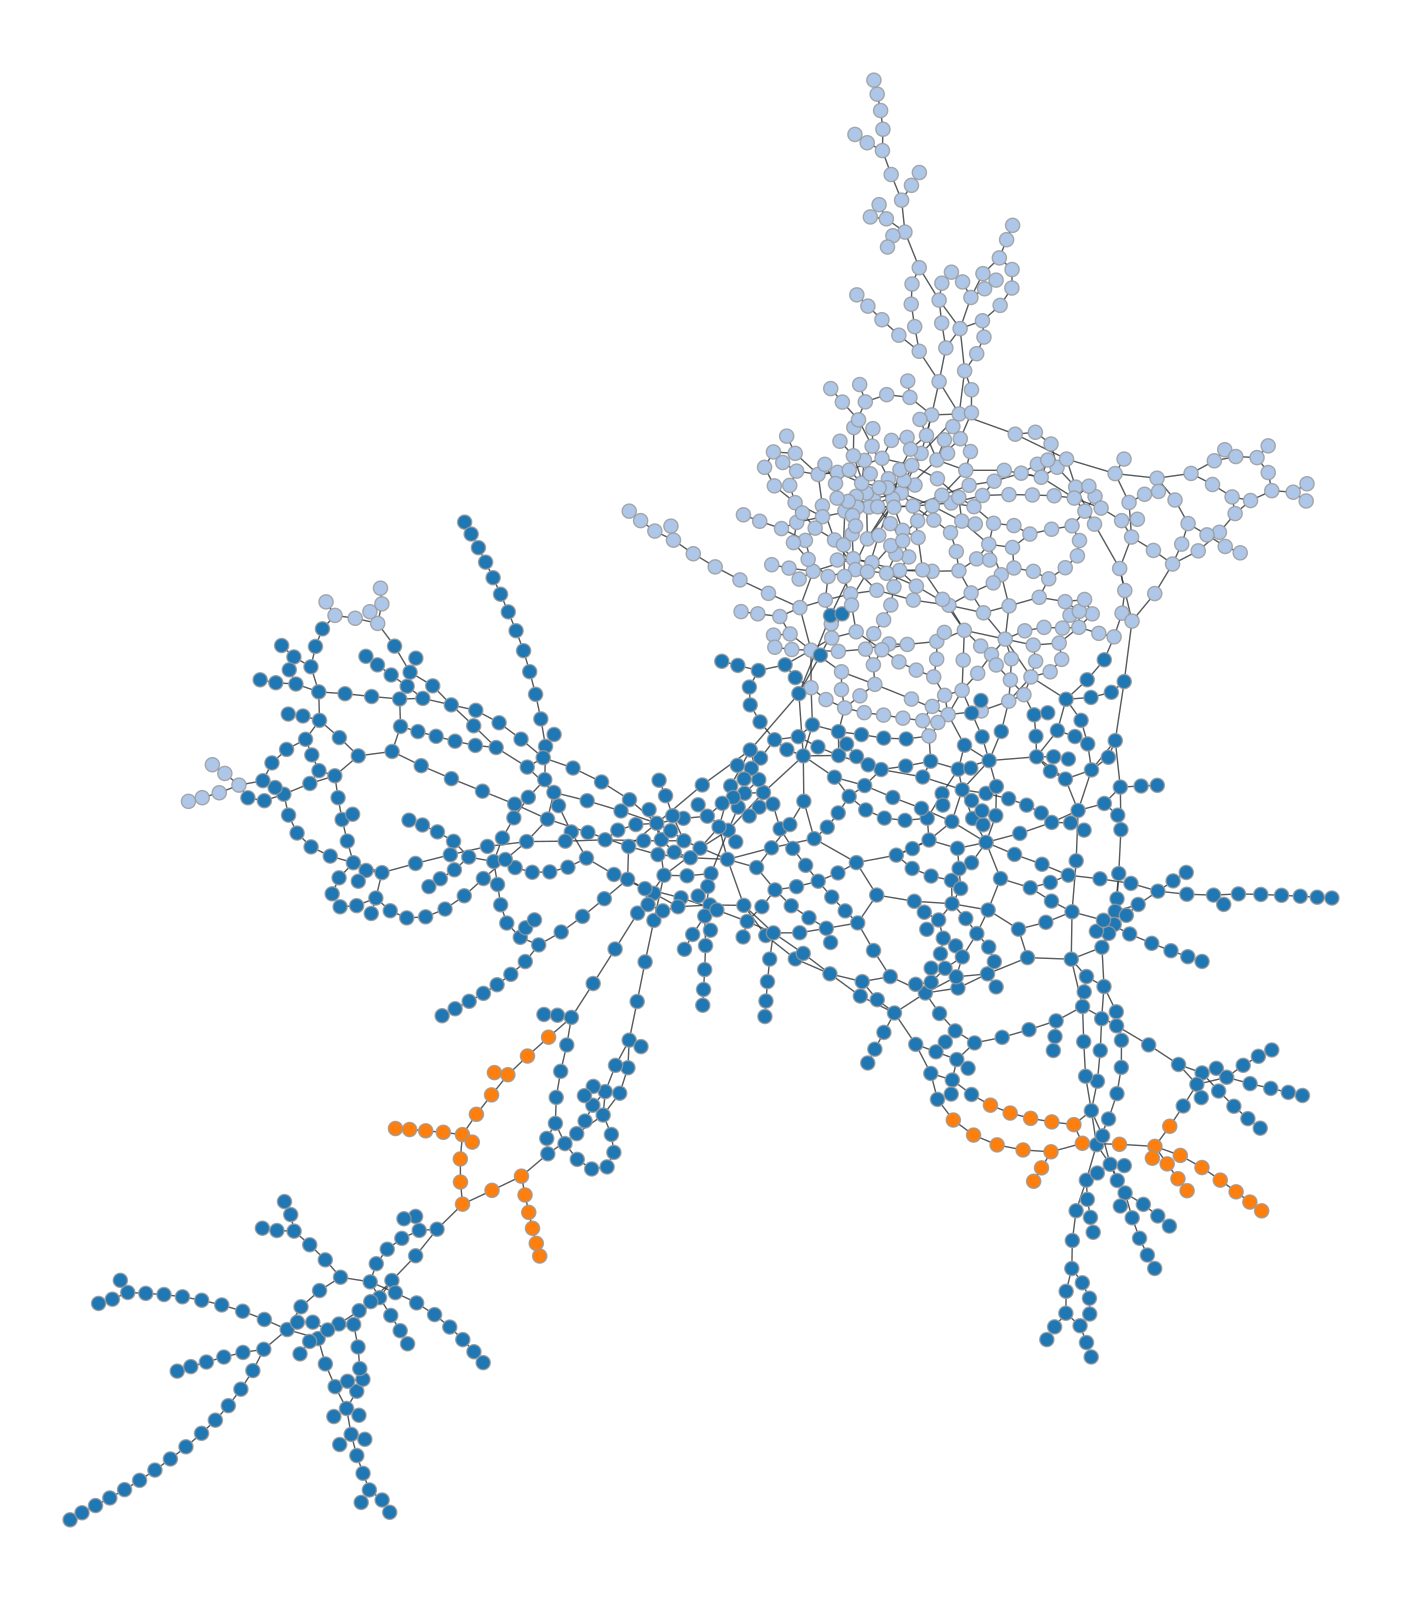

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2ba32215ef90, at 0x2ba317dfa060>

In [184]:
gt_graph, nx_to_gt_map = nx_to_gt(G_giant)
state = gt.minimize_blockmodel_dl(gt_graph)
membership = state.get_blocks()
partition_gt = {node: int(membership[v]) for node, v in nx_to_gt_map.items()}
unique_groups = sorted(set(partition_gt.values()))  # Get sorted unique group labels
group_map = {old_label: new_label for new_label, old_label in enumerate(unique_groups)}  # Map old labels to new ones
partition_gt_consecutive = {node: group_map[partition_gt[node]] for node in partition_gt}

pos = gt.sfdp_layout(gt_graph)
gt.graph_draw(gt_graph, pos=pos, vertex_fill_color=membership, partition=partition_gt_consecutive ,output_size=(800, 800), output=None)

### (c) Create a degree-preserving randomization

#### Networkx girvan newman

In [229]:
degree_sequence = [d for n, d in G_giant.degree()] 
G_randomized = G_giant.copy()
#double edge swap
num_swaps = 10 * G_randomized.number_of_edges()
G_giant_deg=nx.double_edge_swap(G_randomized, nswap=num_swaps, max_tries=num_swaps * 10, seed=123)
communities_generator = girvan_newman(G_giant_deg)
top_level_communities = next(communities_generator)
communities = [list(community) for community in top_level_communities]

partition_gn_deg = {}
for community_id, community in enumerate(communities):
    for node in community:
        partition_gn_deg[node] = community_id

/tmp/ipykernel_29650/3183085173.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set2', len(community_ids))


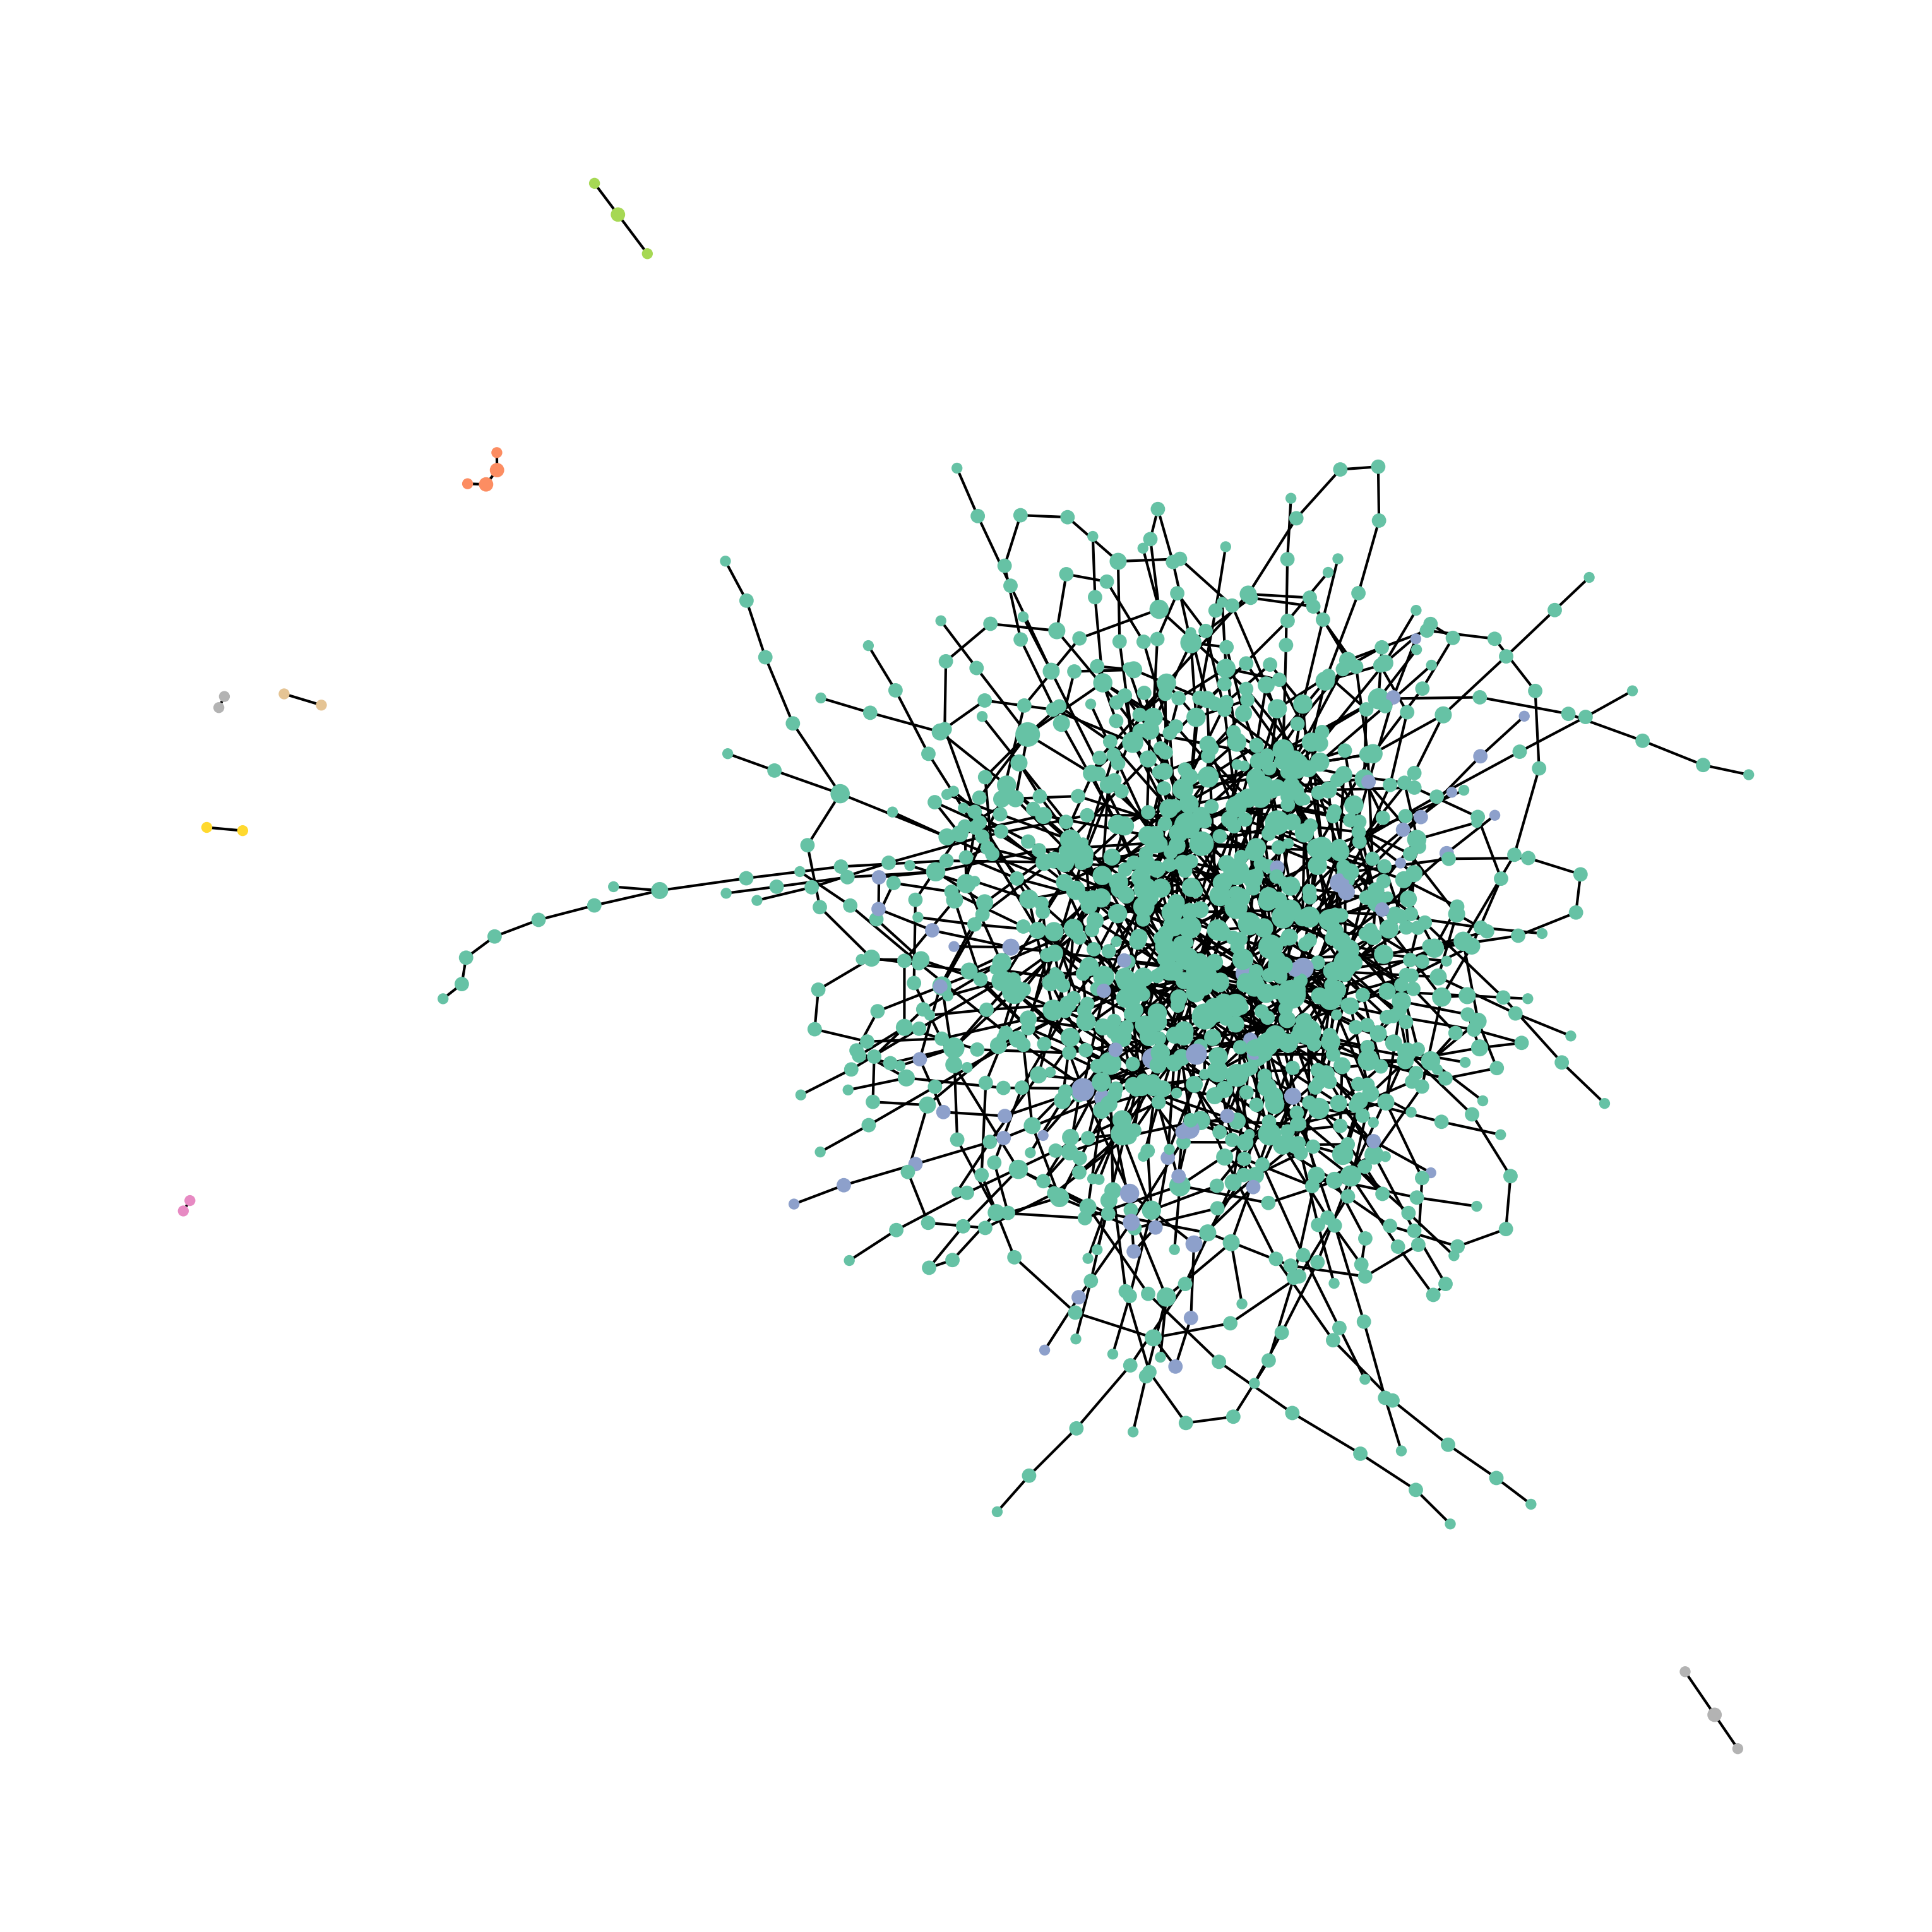

In [230]:
community_ids = list(set(partition_gn_deg.values()))
cmap = cm.get_cmap('Set2', len(community_ids))
colors = [cmap(partition_gn_deg[node]) for node in G_giant_deg.nodes()]
node_sizes = [G_giant_deg.degree(node) * 10 for node in G_giant_deg.nodes()]  # Scale factor can be adjusted

plt.figure(figsize=(10, 10),dpi=300)
pos = nx.spring_layout(G_giant_deg)
nx.draw(G_giant_deg, pos, node_color=colors, node_size=node_sizes, with_labels=False, cmap='Set2')
#plt.title("Degree Preserving Randmization Network (GCC)")
plt.show()

### graphtool minizie SBM description length

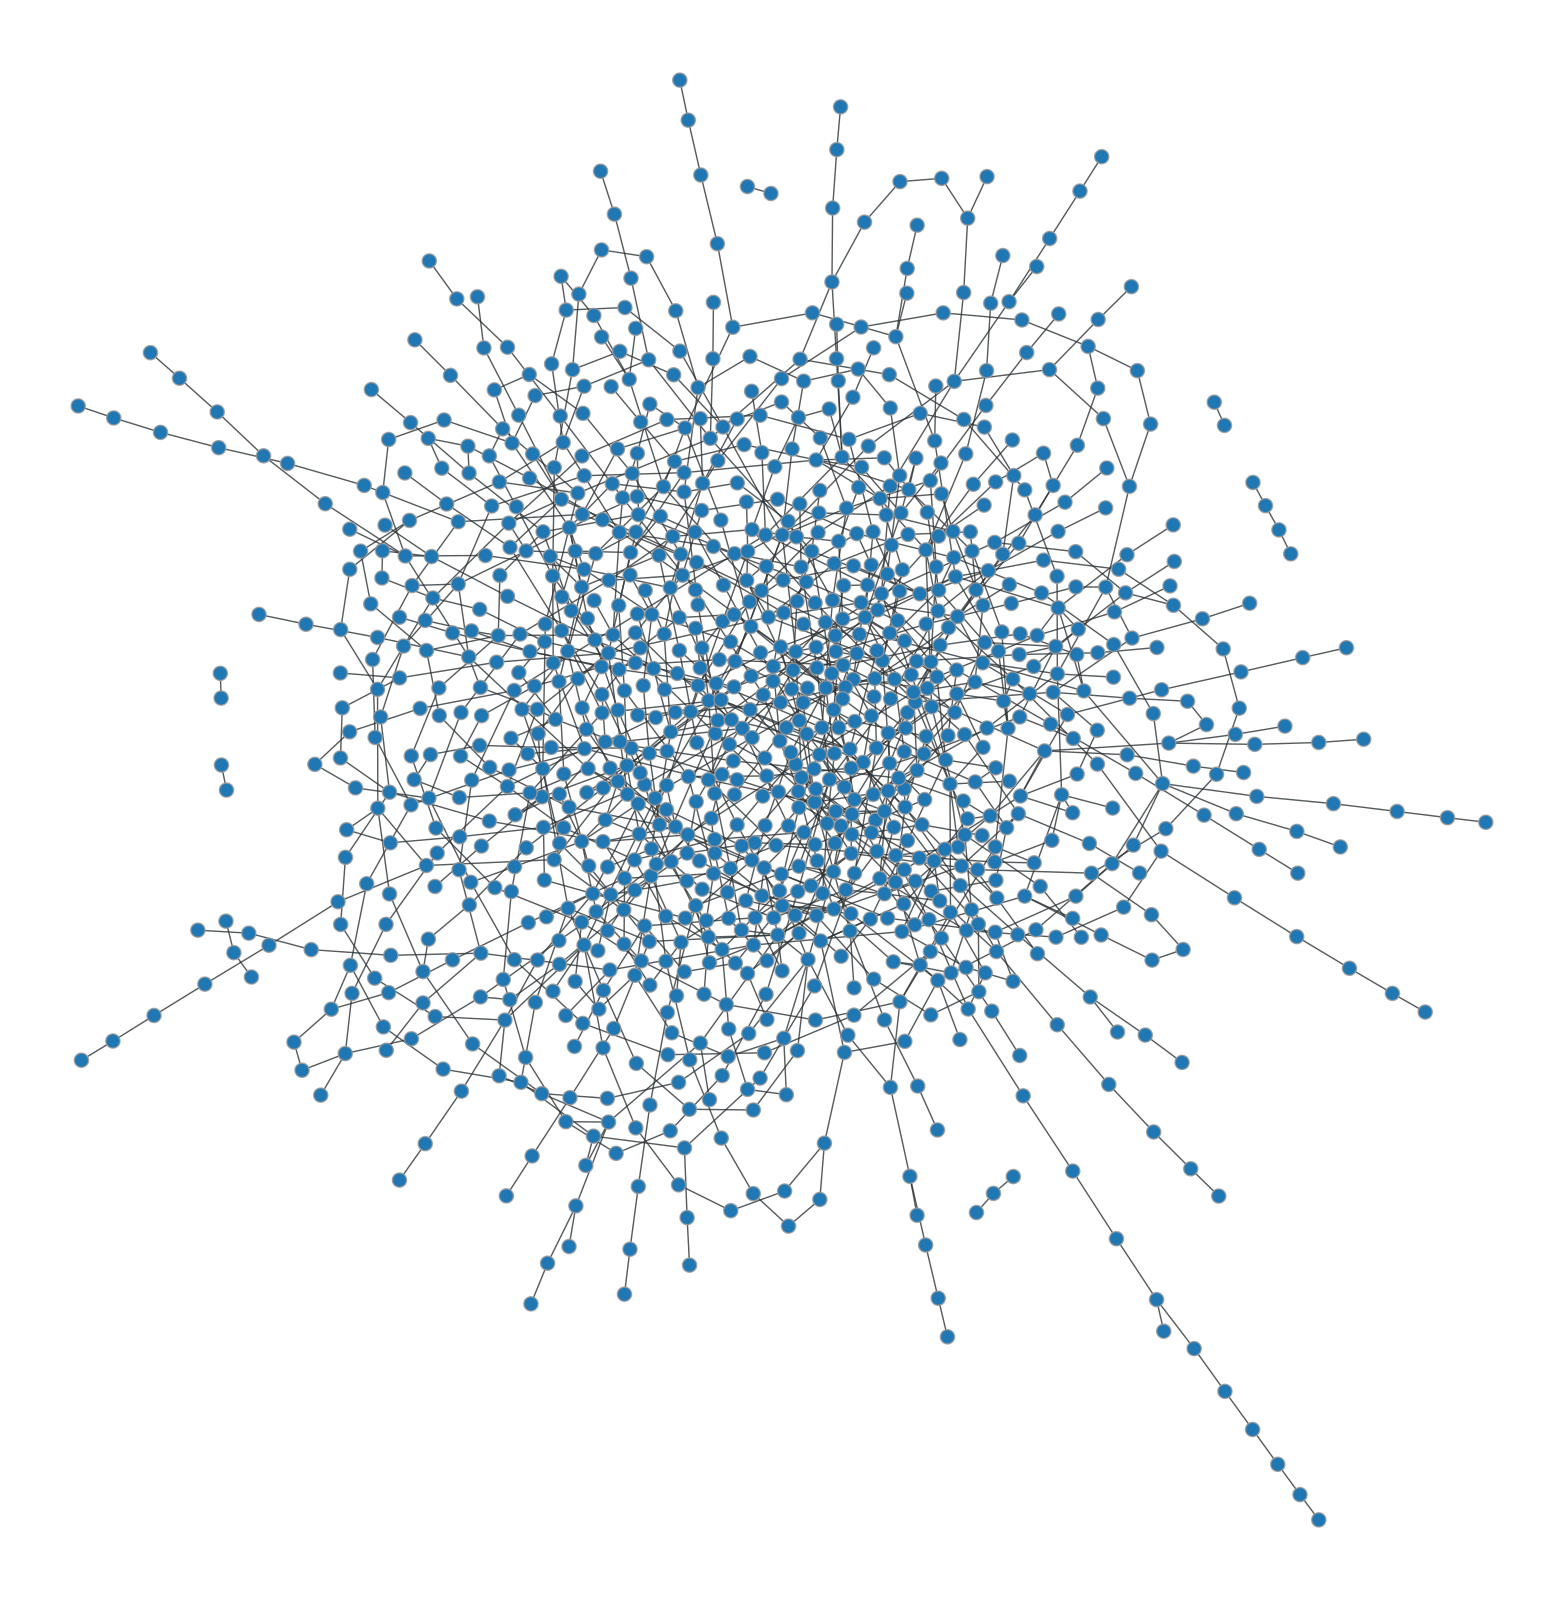

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2ba3225bd280, at 0x2ba320d8de50>

In [231]:
gt_graph_deg, nx_to_gt_map_deg = nx_to_gt(G_giant_deg)
state_deg = gt.minimize_blockmodel_dl(gt_graph_deg)
membership = state_deg.get_blocks()
partition_gt_deg = {node: int(membership[v]) for node, v in nx_to_gt_map_deg.items()}
pos = gt.sfdp_layout(gt_graph_deg)
gt.graph_draw(gt_graph_deg, pos=pos, vertex_fill_color=membership,parittion=partition_gt_deg, output_size=(800, 800), output=None)

### (d) How to compare between different partitions

- **Network mutual information (NMI)**, from [Danon et al., 2005](https://iopscience.iop.org/article/10.1088/1742-5468/2005/09/P09008)
  - **Formula:**
    $$
    \text{NMI}(A, B) = \frac{2 \times I(A, B)}{H(A) + H(B)}
    $$
    where $I(A, B)$ is the mutual information between partition $A$ and partition $B$, and $H(A)$ and $H(B)$ are the entropies of partition $A$ and $B$, respectively.
  - **Description:** NMI is a symmetric measure of the similarity between two partitions, based on the amount of shared information. It is commonly used in clustering comparison as it accounts for the amount of uncertainty in each partition.

- **Variation of Information (VI)**, from [Meila, 2007](https://jmlr.org/papers/volume8/meila07a/meila07a.pdf)
  - **Formula:**
    $$
    \text{VI}(A, B) = H(A) + H(B) - 2 \times I(A, B)
    $$
    where $H(A)$ and $H(B)$ are the entropies of partitions $A$ and $B$, and $I(A, B)$ is the mutual information between $A$ and $B$.
  - **Description:** VI is an information-theoretic metric that quantifies the amount of information lost and gained when transitioning from one partition to another. Lower values indicate more similar partitions.

- **Jaccard Index**, from [Wagner & Wagner, 2007](https://publikationen.bibliothek.kit.edu/1000008441)
  - **Formula:**
    $$
    J(A, B) = \frac{|A \cap B|}{|A \cup B|}
    $$
    where $|A \cap B|$ is the size of the intersection of partitions $A$ and $B$, and $|A \cup B|$ is the size of the union.
  - **Description:** The Jaccard Index measures the similarity between two sets (or partitions) by comparing the size of the intersection relative to the union. It ranges from 0 (completely dissimilar) to 1 (identical).

**NMI (from graphtool)**

In [233]:
partition_gn_list = [partition_gn[node] for node in sorted(partition_gn.keys())]
partition_gn_deg_list = [partition_gn_deg[node] for node in sorted(partition_gn_deg.keys())]
nmi_gn=gt.mutual_information(partition_gn_list, partition_gn_deg_list,norm=False)
nmi_gn_norm=gt.mutual_information(partition_gn_list, partition_gn_deg_list,norm=True)
nmi_gn_adjusted=gt.mutual_information(partition_gn_list, partition_gn_deg_list,adjusted=True)
print(f"NMI between partition_gn and partition_gn_deg: {nmi_gn}")
print(f"Normalized NMI between partition_gn and partition_gn_deg: {nmi_gn_norm}")
print(f"Adjusted NMI between partition_gn and partition_gn_deg: {nmi_gn_adjusted}")

NMI between partition_gn and partition_gn_deg: 0.002820280659606489
Normalized NMI between partition_gn and partition_gn_deg: 0.007569775375012611
Adjusted NMI between partition_gn and partition_gn_deg: -0.0029036726931792206


In [252]:
len(partition_gt_list)

1039

In [253]:
len(partition_gt_deg_list)

1039

In [261]:
partition_gt_list = [partition_gt_consecutive[node] for node in sorted(partition_gt_consecutive.keys())]
partition_gt_deg_list = [partition_gt_deg[node] for node in sorted(partition_gt_deg.keys())]

nmi_gt = gt.mutual_information(partition_gt_list, partition_gt_deg_list, norm=False)
nmi_gt_norm = gt.mutual_information(partition_gt_list, partition_gt_deg_list, norm=True)
nmi_gt_adjusted = gt.mutual_information(partition_gt_list, partition_gt_deg_list, adjusted=True)

print(f"NMI between partition_gt and partition_gt_deg: {nmi_gt}")
print(f"Normalized NMI between partition_gt and partition_gt_deg: {nmi_gt_norm}")
print(f"Adjusted NMI between partition_gt and partition_gt_deg: {nmi_gt_adjusted}")

NMI between partition_gt and partition_gt_deg: 0.0
Normalized NMI between partition_gt and partition_gt_deg: 0.0
Adjusted NMI between partition_gt and partition_gt_deg: 1.2360710678506832e-15


In [263]:
def mutual_information(part1, part2):
    total = len(part1)
    joint_counts = Counter((part1[node], part2[node]) for node in part1 if node in part2)
    part1_counts = Counter(part1.values())
    part2_counts = Counter(part2.values())

    mi_value = 0
    for (label1, label2), joint_count in joint_counts.items():
        prob_joint = joint_count / total
        prob1 = part1_counts[label1] / total
        prob2 = part2_counts[label2] / total
        mi_value += prob_joint * math.log(prob_joint / (prob1 * prob2))
    
    return mi_value

In [264]:
def normalized_mutual_information(part1, part2):
    common_keys = set(part1.keys()) & set(part2.keys()) 
    if not common_keys:
        return 0.0 

    part1_restricted = {k: part1[k] for k in common_keys}
    part2_restricted = {k: part2[k] for k in common_keys}

    mi = mutual_information(part1_restricted, part2_restricted)
    h1 = entropy(part1_restricted)
    h2 = entropy(part2_restricted)
    return 2 * mi / (h1 + h2) if (h1 + h2) != 0 else 1 

**NMI (from defined function)**

In [265]:
nmi_gn = normalized_mutual_information(partition_gn, partition_gn_deg)
nmi_gt = normalized_mutual_information(partition_gt_consecutive, partition_gt_deg)
print(f"NMI between partition_gn and partition_gn_deg: {nmi_gn}")
print(f"NMI between partition_gn and partition_gn_deg: {nmi_gt}")

NMI between partition_gn and partition_gn_deg: 0.007569775375019062
NMI between partition_gn and partition_gn_deg: 0.0


**VI**

In [266]:
def variation_of_information(part1, part2):
    common_keys = set(part1.keys()) & set(part2.keys()) 
    if not common_keys:
        return float('inf')
    part1_restricted = {k: part1[k] for k in common_keys}
    part2_restricted = {k: part2[k] for k in common_keys}

    h1 = entropy(part1_restricted)
    h2 = entropy(part2_restricted)
    mi = mutual_information(part1_restricted, part2_restricted)
    return h1 + h2 - 2 * mi

In [267]:
vi_gn = variation_of_information(partition_gn, partition_gn_deg)
vi_gt = variation_of_information(partition_gt_consecutive, partition_gt_deg)
print(f"VI between partition_gn and partition_gn_deg: {vi_gn}")
print(f"VI between partition_gn and partition_gn_deg: {vi_gt}")

VI between partition_gn and partition_gn_deg: 0.7395019349604138
VI between partition_gn and partition_gn_deg: 0.8105295255245295


**Jaccard index**

In [268]:
part1=partition_gn
part2=partition_gn_deg

In [271]:
def jaccard_index(part1, part2):
    intersection = len(set(part1.items()) & set(part2.items()))
    union = len(set(part1.items()) | set(part2.items()))
    return intersection / union
jaccard_gn = jaccard_index(partition_gn, partition_gn_deg)
jaccard_gt = jaccard_index(partition_gt_consecutive, partition_gt_deg)

print(f"Jaccard Index between partition_gn and partition_gn_deg: {jaccard_gn}")
print(f"Jaccard Index between partition_gt and partition_gt_deg: {jaccard_gt}")

Jaccard Index between partition_gn and partition_gn_deg: 0.6584197924980048
Jaccard Index between partition_gt and partition_gt_deg: 0.4390581717451524
